# Projeto Wine Scrapper

> Um sistema para extração de dados e análise em sites de comércio e avaliação de vinhos

***


## Parte 1 - Web scrapper do site da Wine.com.br

### 1.1. Testes com páginas individuais

In [1]:
import requests
page = requests.get("https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html")

from bs4 import BeautifulSoup as bs

soup = bs(page.content, 'html.parser')


product = soup.find('article', class_='ProductDisplay')

ProductName = product.find('div', class_='ProductDisplay-name')
product_name_a = ProductName.find('a')

print(product_name_a['title'])
print("https://wine.com.br" + product_name_a['href'])

country = product.find(class_="Country")
print(country.span.text)

wine_type = product.find(class_="ProductDisplay-type")
print(wine_type.span.text)

wine_description = product.find(class_="ProductDisplay-descriptionText")
print(wine_description.text)
      
# print(product_name_a.prettify())

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016
https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Chile
tinto
Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias


In [2]:
# Buscando Notas e numero de avaliações
import re

wine_rating = product.find('div',class_='Rating')
wine_evaluation_tag = wine_rating.find('evaluation-tag')
if (wine_evaluation_tag):
    wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
    wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
else:
    wine_evaluation = None
    wine_rating_count = 0

print(str(wine_rating))
print(wine_evaluation)
print(wine_rating_count)

<div class="Rating">
<div class="Rating-stars">
<div class="vue-evaluation-tag">
<evaluation-tag :evaluation="4.0"></evaluation-tag>
</div>
</div>
<a class="Rating-count" href="/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html#Comments">(7)</a>
</div>
4.0
7


In [3]:
# Buscando Preço

price_box = product.find(class_="ProductDisplay-priceBox")

lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
print(lowest_price)
print(full_price)

discount = 1-float(lowest_price)/float(full_price)
print(discount)

145.76
180.90
0.1942509673852958


In [4]:
# Buscando Número de Páginas

pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
int(pages_list[len(pages_list)-1].a.text)

47

In [5]:
# Juntando tudo para processar a lista de uma só página

wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

for wine_item in wine_list:
    wine = wine_item.find('article', class_='ProductDisplay')

    wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
    wine_link = "https://wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
    wine_country = wine.find(class_="Country").span.text
    wine_type = wine.find(class_="ProductDisplay-type").span.text
    wine_description = wine.find(class_="ProductDisplay-descriptionText").text
    
    wine_rating = wine.find('div',class_='Rating')
    wine_evaluation_tag = wine_rating.find('evaluation-tag')
    if (wine_evaluation_tag):
        wine_evaluation = re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group()
        wine_rating_count = re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group()
    else:
        wine_evaluation = None
        wine_rating_count = 0
    
    price_box = wine.find(class_="ProductDisplay-priceBox")

    lowest_price = price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text
    full_price = price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text
    discount = 1-float(lowest_price)/float(full_price)
    
    
    print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_description, ";", wine_link)

Pérez Cruz Limited Edition D.O. Valle del Maipo Cabernet Franc 2016 ; 4.0 ; 7 ; Chile ; tinto ; 145.76 ; 180.90 ; 0.1942509673852958 ; Frutado, taninos presentes, médio corpo, fresco, amadeirado, especiarias ; https://wine.com.br/vinhos/perez-cruz-limited-edition-d-o-valle-del-maipo-cabernet-franc-2016/prod20081.html
Finca La Chamiza Martín Alsina Malbec 2014 ; None ; 0 ; Argentina ; tinto ; 292.82 ; 495.90 ; 0.4095180479935471 ; Frutado, amadeirado, corpo de médio para encorpado, taninos presentes, acidez agradável ; https://wine.com.br/vinhos/finca-la-chamiza-martin-alsina-malbec-2014/prod20028.html
Domaine L'Ostal Cazes Grand Vin 2015 ; None ; 0 ; França ; tinto ; 258.71 ; 335.90 ; 0.22980053587377192 ; Encorpado, boa acidez, taninos macios ; https://wine.com.br/vinhos/domaine-l-ostal-cazes-grand-vin-2015/prod20143.html
Echo de Lynch-Bages A.O.C. Pauillac 2014 ; None ; 0 ; França ; tinto ; 721.06 ; 1056.90 ; 0.3177594852871607 ; Exuberante, encorpado, taninos presentes, boa acidez, 

In [22]:
import requests
from lxml.html import fromstring
from itertools import cycle
import traceback
import timeit

def get_proxies():
    url = 'https://free-proxy-list.net/'
    start = timeit.timeit()
    response = requests.get(url)
    end = timeit.timeit()
    print(end - start)
    parser = fromstring(response.text)
    #print (response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:20]:
        #print(i.xpath('.//td[7][contains(text(),"yes")]'))
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

proxies = get_proxies()
print(proxies)
proxy_pool = cycle(proxies)

url = 'https://httpbin.org/ip'
for i in range(1,11):
    #Get a proxy from the pool
    proxy = next(proxy_pool)
    print("Request #%d"%i)
    try:
        start = timeit.timeit()
        response = requests.get(url,proxies={"http": proxy, "https": proxy})
        end = timeit.timeit()
        print (end - start)
        print(response.json())
    except:
        #Most free proxies will often get connection errors. You will have retry the entire request using another proxy to work. 
        #We will just skip retries as its beyond the scope of this tutorial and we are only downloading a single url 
        print("Skipping. Connnection error")

-0.0018271599992658594
{'103.83.116.210:55443', '109.239.243.211:23500', '123.195.152.139:32287', '194.8.146.167:50510', '27.255.13.134:49328'}
Request #1
-0.0012395980002111173
{'origin': '103.15.240.89'}
Request #2
Skipping. Connnection error
Request #3
Skipping. Connnection error
Request #4
Skipping. Connnection error
Request #5
Skipping. Connnection error
Request #6
Skipping. Connnection error
Request #7
0.0003484030003164662
{'origin': '109.239.243.211'}
Request #8
Skipping. Connnection error
Request #9
-0.0026197279994448763
{'origin': '194.8.146.167'}
Request #10
Skipping. Connnection error


### 1.2. Sistema Winescrapper

In [1]:
# Webscrapper do Site da Wine
# Cabeçalhos e Imports

from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time

URL_RAIZ="https://www.wine.com.br"
URL_BASE = URL_RAIZ+"/vinhos/tinto/cVINHOS-atTIPO_TINTO-p{0}.html"


HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/78.0.3904.87 Safari/537.36'),
    'Connection':'close'
}



In [3]:
# Funções

def get_num_pages(soup):
    
    pages_list = soup.find('div', class_='Pagination').ul.find_all('li')
    num_pages = int(pages_list[len(pages_list)-1].a.text) + 1
    
    return num_pages

def scrape_soup(soup):
    
    list_name=[]
    list_link, list_country, list_type, list_description= [], [], [], []
    list_evaluation, list_rating_count= [], []
    list_lowest_price, list_full_price, list_discount= [], [], []
    
    wine_list = soup.find('div', class_='ProductList-content').ul.find_all('li')

    for wine_item in wine_list:
        
        try:
            wine = wine_item.find('article', class_='ProductDisplay')

            wine_name = wine.find('div', class_='ProductDisplay-name').a['title']
            wine_link = "wine.com.br" + wine.find('div', class_='ProductDisplay-name').a['href']
            wine_country = wine.find(class_="Country").span.text
            wine_type = wine.find(class_="ProductDisplay-type").span.text
            wine_description = wine.find(class_="ProductDisplay-descriptionText").text
        
            wine_rating = wine.find('div',class_='Rating')
            wine_evaluation_tag = wine_rating.find('evaluation-tag')
            if (wine_evaluation_tag):
                wine_evaluation = float(re.compile(r"\d.\d").search(wine_evaluation_tag.prettify()).group())
                wine_rating_count = float(re.search(r"\d+", wine_rating.find(class_='Rating-count').text).group())
            else:
                wine_evaluation = 0
                wine_rating_count = 0
    
        
            price_box = wine.find(class_="ProductDisplay-priceBox")

            lowest_price = float(price_box.find(class_="Price--lowestPrice").find(class_="Price-raw").text)
            full_price = float(price_box.find(class_="Price--fullPrice").find(class_="Price-raw").text)
            discount = 1-float(lowest_price)/float(full_price)
        except:
            if wine_name:
                print('skip incomplete item:', wine_name)
                continue
            else:
                print("skip incomplete item: no name")
                continue
        
        list_name.append(wine_name)
        list_link.append(wine_link)
        list_country.append(wine_country)
        list_type.append(wine_type)
        list_description.append(wine_description)
        
        list_evaluation.append(wine_evaluation)
        list_rating_count.append(wine_rating_count)

        list_lowest_price.append(lowest_price)
        list_full_price.append(full_price)
        list_discount.append(discount)
        
        ###print(wine_name,";", wine_evaluation, ";", wine_rating_count, ";", wine_country, ";", wine_type, ";", lowest_price, ";", full_price, ";", discount,";", wine_link)
    
    df = pd.DataFrame({
        'wine_name': list_name,
        'link': list_link,
        'country': list_country,
        'type': list_type,
        'description': list_description,
        'evaluation': list_evaluation,
        'rating_count': list_rating_count,
        'lowest_price': list_lowest_price,
        'full_price': list_full_price,
        'discount': list_discount
    })
    
    return df
        
    

def get_soup(page_url, retry_count=0):
    
    session= requests.Session()
    session.trust_env = False
    
    print("Iniciando session_get")
    
    try:
        response = session.get(page_url, headers=HEADERS)
        print("\nScraping page:",page_url," = ", response)
        soup = bs(response.content, 'html.parser')
        return soup
    except:
        print("Get falhou")
        retry_count += 1
        if retry_count <= 3:
            print("retry get")
            session = requests.Session()
            get_soup(page_url, retry_count)
        else:
            raise
    
    


    


In [4]:
# Módulo Principal - Processamento do Site

pages_to_scrape = 4

current_page = 1

wine_df = pd.DataFrame(columns=['wine_name','link','country','type','description','evaluation','rating_count','lowest_price','full_price','discount'])

while (current_page != pages_to_scrape):
    
    print("Iniciando get_soup pagina", current_page)
    
    wine_soup = get_soup(URL_BASE.format(current_page))
    
    if current_page == 1:
        pages_to_scrape = get_num_pages(wine_soup)
    
    new_df = scrape_soup(wine_soup)
    wine_df= wine_df.append(new_df, ignore_index=True)
    
    ###print(current_page)
    
    time.sleep(10)
    current_page += 1
    
print("Scrape finished.")
wine_df



Iniciando get_soup pagina 1
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p1.html  =  <Response [200]>
Iniciando get_soup pagina 2
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p2.html  =  <Response [200]>
skip incomplete item: WineBox Apothic Crush + Taças
Iniciando get_soup pagina 3
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p3.html  =  <Response [200]>
Iniciando get_soup pagina 4
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p4.html  =  <Response [200]>
skip incomplete item: WineBox Carnivor Zinfandel 2017 - 4 garrafas
Iniciando get_soup pagina 5
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIPO_TINTO-p5.html  =  <Response [200]>
Iniciando get_soup pagina 6
Iniciando session_get

Scraping page: https://www.wine.com.br/vinhos/tinto/cVINHOS-atTIP

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
0,Pinhal Da Torre Special D.O.C. Tejo 2008,wine.com.br/vinhos/pinhal-da-torre-special-d-o...,Portugal,tinto,"Maduro, elegante, boa acidez, taninos macios, ...",5.0,1.0,758.71,999.9,0.241214
1,Tormentoso Syrah 2016,wine.com.br/vinhos/tormentoso-syrah-2016/prod2...,África do Sul,tinto,"Médio corpo, taninos macios, boa acidez, média...",3.5,46.0,58.71,122.9,0.522295
2,Jiménez-Landi Bajondillo D.O. Méntrida 2017,wine.com.br/vinhos/jimenez-landi-bajondillo-d-...,Espanha,tinto,"Leve, acidez marcantes, taninos macios",4.0,13.0,98.71,119.9,0.176731
3,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",0.0,0.0,352.82,495.9,0.288526
4,Maycas del Limarí Reserva Especial Pinot Noir ...,wine.com.br/vinhos/maycas-del-limari-reserva-e...,Chile,tinto,"Bom corpo, acidez presente, taninos sedosos, f...",4.0,25.0,166.94,199.9,0.164882
...,...,...,...,...,...,...,...,...,...,...
284,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,wine.com.br/vinhos/ropiteau-freres-les-plants-...,França,tinto,"Corpo de leve para médio, fresco, taninos deli...",4.5,80.0,66.94,79.9,0.162203
285,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,368.0,130.47,179.9,0.274764
286,Root: 1 Casablanca Valley Pinot Noir 2018,wine.com.br/vinhos/root-1-casablanca-valley-pi...,Chile,tinto,"Frutado, corpo de leve para médio, fresco, tan...",4.0,97.0,56.35,64.9,0.131741
287,Canepa Novísimo Cabernet Sauvignon 2019,wine.com.br/vinhos/canepa-novisimo-cabernet-sa...,Chile,tinto,"Corpo de leve para médio, frutado, boa acidez,...",4.0,30.0,43.41,49.9,0.130060


In [5]:
# Análise do dados

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2) & (wine_df.lowest_price < 66.20)]
wine_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
235,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,475.0,64.90,64.90,0.000000
278,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,584.0,41.06,54.90,0.252095
279,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,478.0,54.67,54.67,0.000000


In [6]:
wine_exotic = wine_df.loc[~wine_df.country.isin(['Chile','França','Espanha','Argentina','Itália','Portugal','Brasil','Estados Unidos','Uruguai'])]
wine_exotic.loc[wine_exotic.country == 'China']

#wine_exotic.iloc[2].link

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount


In [7]:
# Exemplo do uso de Describe
wine_df.lowest_price.describe()

count      289.000000
mean       592.508824
std       1717.541760
min         39.880000
25%         76.350000
50%        124.590000
75%        282.240000
max      14598.710000
Name: lowest_price, dtype: float64

In [8]:
# Mais um exemplo de Describe

wine_df.loc[wine_df.evaluation > 0].describe()

,evaluation,rating_count,lowest_price,full_price,discount
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,4.018957,51.853081,264.165213,373.090379,0.199873
std,0.647060,141.741120,868.560666,1376.628999,0.148172
min,1.000000,1.000000,39.880000,49.900000,0.000000
25%,4.000000,3.500000,72.820000,97.900000,0.062049
50%,4.000000,14.000000,98.900000,122.900000,0.201822
75%,4.500000,44.000000,165.760000,212.400000,0.304020
max,5.000000,1482.000000,9303.410000,14794.900000,0.529887


In [9]:
#Exemplo de funções de sumário

print(wine_df.country.describe())
print(wine_df.rating_count.mean())
print(wine_df.country.unique())

count        289
unique        13
top       França
freq          77
Name: country, dtype: object
37.858131487889274
['Portugal' 'África do Sul' 'Espanha' 'Argentina' 'Chile' 'França'
 'Uruguai' 'Itália' 'Estados Unidos' 'Alemanha' 'Austrália' 'Áustria'
 'Líbano']


In [10]:
# Exemplo de groupby
wine_df.groupby('country').lowest_price.min()

country
Alemanha           86.94
Argentina          52.82
Austrália          58.71
Chile              39.88
Espanha            41.06
Estados Unidos     54.00
França             52.82
Itália             58.71
Líbano            119.88
Portugal           55.18
Uruguai           231.65
África do Sul      58.71
Áustria           126.94
Name: lowest_price, dtype: float64

In [11]:
# Exemplo de min
wine_deals.groupby('country').lowest_price.min()

country
Espanha    41.06
França     54.67
Name: lowest_price, dtype: float64

In [12]:
# Exemplo de Apply
wine_df.groupby(['country','type']).apply(lambda df: df.loc[df.rating_count.idxmax()])

,,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
country,type,,,,,,,,,,
Alemanha,tinto,Ernst Loosen Winemakers Select Pfalz Edition P...,wine.com.br/vinhos/ernst-loosen-winemakers-sel...,Alemanha,tinto,"Leve, acidez presente, taninos sedosos",4.0,23.0,96.35,119.90,0.196414
Argentina,tinto,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,368.0,130.47,179.90,0.274764
Austrália,tinto,Oxford Landing Shiraz 2017,wine.com.br/vinhos/oxford-landing-shiraz-2017/...,Austrália,tinto,"Corpo de leve para médio, taninos macios, boa ...",3.0,12.0,58.71,120.90,0.514392
Chile,tinto,Undurraga Talagante Reserva Pinot Noir 2018,wine.com.br/vinhos/undurraga-talagante-reserva...,Chile,tinto,"Fresco, jovem, corpo médio e com bela acidez",4.0,561.0,58.90,58.90,0.000000
Espanha,tinto,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,584.0,41.06,54.90,0.252095
Estados Unidos,tinto,Bear Flag Red Blend 2018,wine.com.br/vinhos/bear-flag-red-blend-2018/pr...,Estados Unidos,tinto,"Encorpado, macio, saboroso e com final persist...",4.0,1482.0,62.24,68.90,0.096662
França,tinto,Café du Midi IGP Pays dOc Cabernet Sauvignon 2019,wine.com.br/vinhos/cafe-du-midi-igp-pays-doc-c...,França,tinto,"Bom corpo, boa acidez e final agradável",4.0,636.0,58.75,58.75,0.000000
Itália,tinto,Corello D.O.C. Sicília Nero d'Avola 2017,wine.com.br/vinhos/corello-d-o-c-sicilia-nero-...,Itália,tinto,"Corpo de leve para médio, fresco, taninos sedosos",4.0,95.0,62.24,75.90,0.179974
Líbano,tinto,Chateau Oumsiyat Red Jaspe 2014,wine.com.br/vinhos/chateau-oumsiyat-red-jaspe-...,Líbano,tinto,"Encorpado, robusto e frutado",3.0,6.0,119.88,195.90,0.388055


In [13]:
# Exemplo de sort

sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])
sorted_wines

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount
278,Toro Loco D.O.P. Utiel-Requena Tinto Superior ...,wine.com.br/vinhos/toro-loco-d-o-p-utiel-reque...,Espanha,tinto,"Frutado, corpo de leve para médio, taninos mac...",4.5,584.0,41.06,54.90,0.252095
279,Gérard Bertrand Narbo Martius Réserve Blend 2018,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Elegante, taninos aveludados e final agradável",4.5,478.0,54.67,54.67,0.000000
235,Gérard Bertrand Narbo Martius Cabernet Sauvign...,wine.com.br/vinhos/gerard-bertrand-narbo-marti...,França,tinto,"Encorpado, taninos finos, final longo",4.5,475.0,64.90,64.90,0.000000


In [14]:
# Exemplo de iterator em DataFrame

for index, row in sorted_wines.iterrows():
    print(row.wine_name, "\t", row.link)



Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018 	 wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html
Gérard Bertrand Narbo Martius Réserve Blend 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-reserve-blend-2018/prod23409.html
Gérard Bertrand Narbo Martius Cabernet Sauvignon 2018 	 wine.com.br/vinhos/gerard-bertrand-narbo-martius-cabernet-sauvignon-2018/prod23408.html


### 1.3. Análise Descritiva - Wine


In [15]:
# Gráficos

import matplotlib.pyplot as plt

#wine_df.boxplot(column=wine_df.groupby('country'))
wine_df.groupby('country')['lowest_price'].describe()


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Alemanha,2.0,91.645000,6.653875,86.94,89.2925,91.645,93.9975,96.35
Argentina,29.0,137.152069,88.690533,52.82,75.1800,115.180,146.9400,432.82
Austrália,2.0,58.710000,0.000000,58.71,58.7100,58.710,58.7100,58.71
Chile,46.0,164.374130,205.081850,39.88,67.8225,93.410,166.6450,1066.94
Espanha,42.0,117.614286,86.512340,41.06,66.1300,87.530,135.8800,488.12
Estados Unidos,28.0,701.297857,1734.977142,54.00,117.5300,172.235,265.1025,8938.71
França,77.0,1566.055065,2938.446615,52.82,108.1200,258.710,790.4700,14598.71
Itália,24.0,261.238750,226.949766,58.71,105.1725,177.530,311.0550,941.06
Líbano,2.0,131.060000,15.810908,119.88,125.4700,131.060,136.6500,142.24


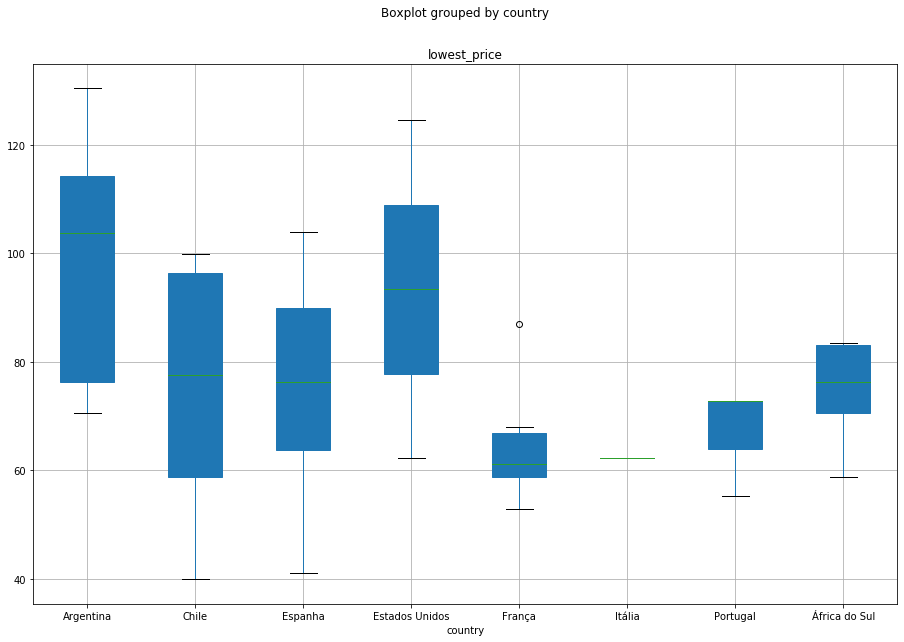

In [16]:
wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

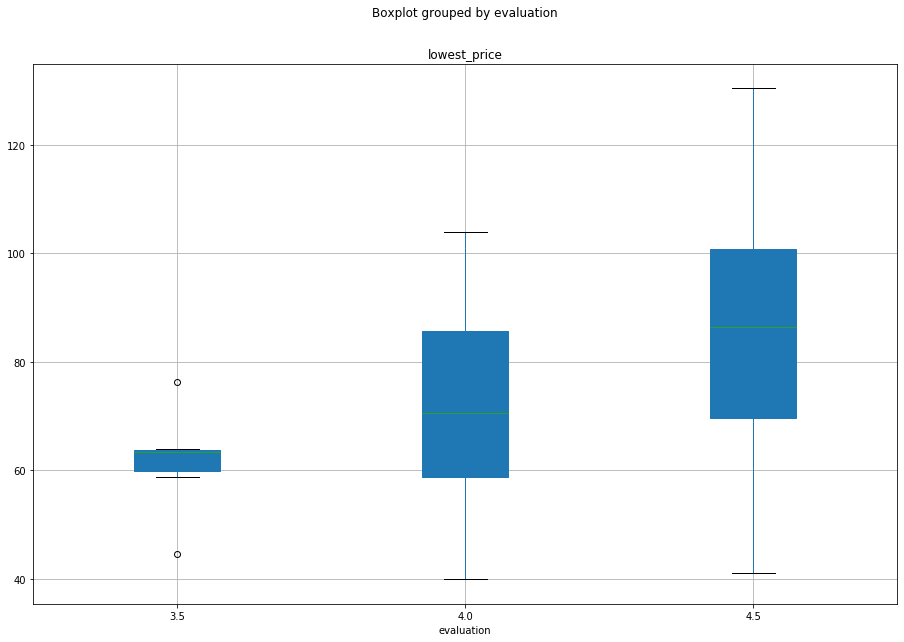

In [17]:
wine_plot = wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 1000.0) & (wine_df.rating_count > 34.0)]
wine_plot.boxplot(by='evaluation',column=['lowest_price'], figsize=(15,10), patch_artist=True)

In [18]:
wine_df.evaluation.corr(wine_df.lowest_price)

-0.2854297211644895

## Parte 2 - Busca no Vivino

### 2.1. Testes Individuais

#### URL Encoding para buscar no Vivino


In [19]:
import urllib.parse

wine_deals = wine_df.loc[(wine_df.rating_count>=36) & (wine_df.evaluation >= 4.2)]
sorted_wines = wine_deals.sort_values(by=['lowest_price','evaluation'])

#row = next(sorted_wines.iterrows())[1]
#Pegando o segundo da lista
row = sorted_wines.iloc[0]

query_url = urllib.parse.quote(row.wine_name)
row.wine_name

#for index, row in sorted_wines.iterrows():
#    query_url = urllib.parse.quote(row.wine_name)
#    print(query_url.replace("%20","+"), "\t", 'https://'+row.link)

'Toro Loco D.O.P. Utiel-Requena Tinto Superior 2018'

In [20]:
new_url = 'https://www.vivino.com/search/wines?q='+query_url.replace("%20","+")
new_url

'https://www.vivino.com/search/wines?q=Toro+Loco+D.O.P.+Utiel-Requena+Tinto+Superior+2018'

In [21]:
row.link

'wine.com.br/vinhos/toro-loco-d-o-p-utiel-requena-tinto-superior-2018/prod23299.html'

#### Busca no Vivino


In [ ]:
vivino_soup = get_soup(new_url)

#print(vivino_soup.body.prettify())

In [ ]:
vivino_search_item = vivino_soup.find('div', class_="wine-card__content")

vivino_name = vivino_search_item.find('span', class_="wine-card__name").text.replace("\n","")
print(vivino_name)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

vivino_price = vivino_search_item.find('div', class_="wine-price")
vivino_price

#### Tentando com Selenium

In [26]:
from selenium import webdriver

browser = webdriver.Chrome('C:\\Users\\gmendonc\\Dev\\Scrapper\\winescrapper\\chromedriver_win32\\chromedriver')
browser.get(new_url)

vivino_soup_byselenium = bs(browser.page_source,'html.parser')

vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")


In [ ]:
vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
vivino_name = vivino_name_card.text.replace("\n","")
print(vivino_name)

vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
print(vivino_link)

vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
try:
    vivino_average_score = float(vivino_average_score_txt.replace(",","."))
except:
    vivino_average_score = vivino_average_score_txt
print(vivino_average_score)

try:
    vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
    vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
except:
    vivino_rating = None
print(vivino_rating)

try:
    vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
    vivino_price = float(vivino_price_txt.replace(",","."))
except:
    vivino_price = None
print(vivino_price)

In [ ]:
browser.close()

### 2.1. Prova de Conceito

> Busca vinhos do dataframe da wine no vivino, acha os dados e cria um novo dataframe.

In [27]:
from selenium import webdriver
from time import perf_counter

VIVINO_SEARCH_URL = 'https://www.vivino.com/search/wines?q='

browser = webdriver.Chrome('C:\\Users\\gmendonc\\Dev\\Scrapper\\winescrapper\\chromedriver_win32\\chromedriver')

reference_df = wine_df

lst_vivino_name, lst_vivino_link, lst_vivino_score, lst_vivino_rating, lst_vivino_price = [], [], [], [], []
lst_original_name = []

for index, row in reference_df.iterrows():
    
    query_url = urllib.parse.quote(row.wine_name)
    new_url = VIVINO_SEARCH_URL+query_url.replace("%20","+")
    
    print("Searching...", new_url)
    
    start_time = perf_counter()
    
    try:
        browser.get(new_url)
        vivino_soup_byselenium = bs(browser.page_source,'html.parser')
        vivino_search_item = vivino_soup_byselenium.find('div', class_="wine-card__content")
        vivino_name_card = vivino_search_item.find('span', class_="wine-card__name")
        vivino_name = vivino_name_card.text.replace("\n","")
        lst_original_name.append(row.wine_name)
        lst_vivino_name.append(vivino_name)

        vivino_link = 'www.vivino.com'+vivino_name_card.a['href']
        lst_vivino_link.append(vivino_link)

        vivino_average_score_txt = vivino_search_item.find('div', class_="average__number").text.replace("\n","")
        try:
            vivino_average_score = float(vivino_average_score_txt.replace(",","."))
        except:
            vivino_average_score = None
        lst_vivino_score.append(vivino_average_score)

        try:
            vivino_rating_txt = vivino_search_item.find('div', class_="average__stars").text
            vivino_rating = float(re.search(r"\d+",vivino_rating_txt).group())
        except:
            vivino_rating = None
        lst_vivino_rating.append(vivino_rating)

        try:
            vivino_price_txt = vivino_search_item.find('span', class_="wine-price-value").text
            vivino_price = float(vivino_price_txt.replace(",","."))
        except:
            vivino_price = None
        lst_vivino_price.append(vivino_price)
    
        time.sleep(2)
    except:
        print("Next!")
    
    elapsed_time = perf_counter()-start_time
    print("tempo: ", elapsed_time)
        
    
browser.close()

df = pd.DataFrame({
        'wine_name' : lst_original_name,
        'vivino_name': lst_vivino_name,
        'vivino_link': lst_vivino_link,
        'vivino_score': lst_vivino_score,
        'vivino_rating': lst_vivino_rating,
        'vivino_price': lst_vivino_price,
    })

df
    
    

Searching... https://www.vivino.com/search/wines?q=Pinhal+Da+Torre+Special+D.O.C.+Tejo+2008
tempo:  10.004016201914055
Searching... https://www.vivino.com/search/wines?q=Tormentoso+Syrah+2016
tempo:  4.626954862762432
Searching... https://www.vivino.com/search/wines?q=Jim%C3%A9nez-Landi+Bajondillo+D.O.+M%C3%A9ntrida+2017
tempo:  5.402706469388704
Searching... https://www.vivino.com/search/wines?q=Finca+La+Chamiza+Mart%C3%ADn+Alsina+Malbec+2014
tempo:  63.13146771139918
Searching... https://www.vivino.com/search/wines?q=Maycas+del+Limar%C3%AD+Reserva+Especial+Pinot+Noir+2017
tempo:  4.043988240922772
Searching... https://www.vivino.com/search/wines?q=Pauillac+De+Lynch-Bages+2015
tempo:  5.265951038363255
Searching... https://www.vivino.com/search/wines?q=Famille+J-M+Cazes+A.O.C.+Saint-Est%C3%A8phe+2015
tempo:  5.939258136692388
Searching... https://www.vivino.com/search/wines?q=Echo+de+Lynch-Bages+A.O.C.+Pauillac+2014
tempo:  5.481236453431848
Searching... https://www.vivino.com/search/

tempo:  4.058574047765433
Searching... https://www.vivino.com/search/wines?q=Ernst+Loosen+Winemakers+Select+Pfalz+Edition+Pinot+Noir+2017
tempo:  4.735286567346975
Searching... https://www.vivino.com/search/wines?q=P%C3%ADxide+D.O.+Ribera+del+Duero+Tempranillo+2016
tempo:  4.804159653324405
Searching... https://www.vivino.com/search/wines?q=Ghost+Pines+Winemakers+Blend+Red+2016
tempo:  4.647165686014432
Searching... https://www.vivino.com/search/wines?q=Teorema+D.O.+Calatayud+Garnacha+2016
tempo:  4.669865212559216
Searching... https://www.vivino.com/search/wines?q=Apothic+Crush+2016
tempo:  3.8387932870282384
Searching... https://www.vivino.com/search/wines?q=MacMurray+Russian+River+Valley+Pinot+Noir+2016
tempo:  5.764339671352445
Searching... https://www.vivino.com/search/wines?q=Frei+Brothers+Reserve+Russian+River+Pinot+Noir+2016
tempo:  4.829821921884559
Searching... https://www.vivino.com/search/wines?q=Carnivor+Zinfandel+2017
tempo:  4.3092205636535255
Searching... https://www.vi

tempo:  5.985498426191043
Searching... https://www.vivino.com/search/wines?q=Baron+Philippe+de+Rothschild+Pays+D%C2%B4Oc+Merlot+2018
tempo:  5.555958083308269
Searching... https://www.vivino.com/search/wines?q=Oxford+Landing+Cabernet+Shiraz+2016
tempo:  4.122231249216384
Searching... https://www.vivino.com/search/wines?q=Petravia+I.G.T.+Puglia+Aglianico+2016
tempo:  5.789028701950883
Searching... https://www.vivino.com/search/wines?q=Domaine+de+Cibadi%C3%A8s+Bellevue+Pinot+Noir+2016
tempo:  4.4313861767391245
Searching... https://www.vivino.com/search/wines?q=Finca+Trapezio+Bo+B%C3%B3+Bourgeois+Cabernet+Sauvignon+2018
tempo:  6.730957864521315
Searching... https://www.vivino.com/search/wines?q=Monte+Araya+Gran+Reserva+D.O.Ca.+Rioja+2013
tempo:  5.428054778456044
Searching... https://www.vivino.com/search/wines?q=Monte+Araya+Reserva+D.O.Ca.+Rioja+2014
tempo:  5.615388682580942
Searching... https://www.vivino.com/search/wines?q=Finca+Trapezio+Bo+B%C3%B3+Bohemian+Malbec+2018
tempo:  6.768

Next!
tempo:  0.17828960994620502
Searching... https://www.vivino.com/search/wines?q=Bridlewood+Paso+Robles+Cabernet+Sauvignon+2017
Next!
tempo:  0.16115493335746578
Searching... https://www.vivino.com/search/wines?q=William+Hill+Central+Coast+Merlot+2017
Next!
tempo:  0.17824147678356894
Searching... https://www.vivino.com/search/wines?q=Canepa+Magnificum+D.O.+Valle+del+Maipo+Cabernet+Sauvignon+2016
Next!
tempo:  0.1835401357648152
Searching... https://www.vivino.com/search/wines?q=Calyptra+Vivendo+Reserve+Assemblage+2016
Next!
tempo:  0.1849866831585132
Searching... https://www.vivino.com/search/wines?q=Canepa+Reserva+Famiglia+Carm%C3%A9n%C3%A8re+2018
Next!
tempo:  0.18578853788949345
Searching... https://www.vivino.com/search/wines?q=Carpineto+D.O.C.+Rosso+di+Montepulciano+2016
Next!
tempo:  0.21281713190546725
Searching... https://www.vivino.com/search/wines?q=Frei+Brothers+Reserve+Cabernet+Sauvignon+2016
Next!
tempo:  0.17914215035625602
Searching... https://www.vivino.com/search/

Next!
tempo:  0.2628015980208147
Searching... https://www.vivino.com/search/wines?q=P%C3%A9rez+Cruz+Winemakers+Selection+2017
Next!
tempo:  0.19234522271062815
Searching... https://www.vivino.com/search/wines?q=La+Jolie+Carignan+2018
Next!
tempo:  0.17621806072975232
Searching... https://www.vivino.com/search/wines?q=Canepa+Fin%C3%ADsimo+Gran+Reserva+Carm%C3%A9n%C3%A8re+2018
Next!
tempo:  0.18704546979415682
Searching... https://www.vivino.com/search/wines?q=Caf%C3%A9+du+Midi+IGP+Pays+dOc+Merlot+2019
Next!
tempo:  0.21571934282201255
Searching... https://www.vivino.com/search/wines?q=Am%C3%ACra+D.O.C.+Sicilia+Nero+D+Avola+2017
Next!
tempo:  0.21730117357401468
Searching... https://www.vivino.com/search/wines?q=Vik+A+2016
Next!
tempo:  0.1741348428672609
Searching... https://www.vivino.com/search/wines?q=La+Veguilla+6+Meses+em+Barrica+2016
Next!
tempo:  0.19287432285364048
Searching... https://www.vivino.com/search/wines?q=Apothic+Red+2017
Next!
tempo:  0.28525681230121336
Searching... 

,wine_name,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Pinhal Da Torre Special D.O.C. Tejo 2008,Pinhal Da Torre Special 2008,www.vivino.com/wines/1440080,4.3,138.0,480.0
1,Tormentoso Syrah 2016,Tormentoso Syrah 2016,www.vivino.com/wines/158476133,3.5,1149.0,NaN
2,Jiménez-Landi Bajondillo D.O. Méntrida 2017,Jiménez-Landi Bajondillo 2017,www.vivino.com/wines/152761412,3.6,193.0,NaN
3,Finca La Chamiza Martín Alsina Malbec 2014,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,101.0,168.0
4,Maycas del Limarí Reserva Especial Pinot Noir ...,Maycas del Limari Reserva Especial Pinot Noir ...,www.vivino.com/wines/152575001,3.7,228.0,NaN
...,...,...,...,...,...,...
140,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,Ropiteau Freres Les Plants Nobles Pinot Noir 2017,www.vivino.com/wines/151221068,3.7,1141.0,NaN
141,Clos de Los Siete By Michel Rolland 2016,Clos de los Siete Clos de Los Siete (by Michel...,www.vivino.com/wines/91011696,3.9,4535.0,97.0
142,Root: 1 Casablanca Valley Pinot Noir 2018,Root 1 Pinot Noir 2018,www.vivino.com/wines/156464792,3.5,322.0,46.9
143,Canepa Novísimo Cabernet Sauvignon 2019,Canepa Novísimo Cabernet Sauvignon 2019,www.vivino.com/wines/160990770,3.3,46.0,NaN


In [28]:
result = pd.merge(reference_df, df, on='wine_name')
result.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
91,Château de Beaucastel Hommage à Jacques Perrin...,wine.com.br/vinhos/chateau-de-beaucastel-homma...,França,tinto,"Denso, exuberante, estruturado, concentrado, b...",0.0,0.0,6739.88,10789.9,0.375353,Château de Beaucastel Hommage à Jacques Perrin...,www.vivino.com/wines/3896910,4.5,503.0,NaN
98,Château La Fleur-Pétrus 2014,wine.com.br/vinhos/chateau-la-fleur-petrus-201...,França,tinto,"Complexo, elegante, corpo de médio para encorp...",4.0,1.0,4044.59,6564.9,0.383907,Château La Fleur-Pétrus Pomerol 2014,www.vivino.com/wines/4237999,4.5,180.0,NaN
17,Château La Fleur-Pétrus A.O.C. Pomerol 2006,wine.com.br/vinhos/chateau-la-fleur-petrus-a-o...,França,tinto,"Aveludado, complexo, boa acidez, corpo de médi...",0.0,0.0,3614.00,6036.9,0.401348,Château La Fleur-Pétrus Pomerol 2006,www.vivino.com/wines/1150888,4.5,452.0,NaN
92,Château Palmer 2005,wine.com.br/vinhos/chateau-palmer-2005/prod194...,França,tinto,"Concentrado, elegante, potente, taninos presen...",0.0,0.0,6502.24,10502.9,0.380910,Château Palmer Alter Ego Margaux 2005,www.vivino.com/wines/1722841,4.3,431.0,NaN
90,Château Lynch-Bages 2015,wine.com.br/vinhos/chateau-lynch-bages-2015/pr...,França,tinto,"Potente, concentrado, taninos presentes, boa a...",0.0,0.0,2418.71,3848.9,0.371584,Château Lynch-Bages Pauillac (Grand Cru Classé...,www.vivino.com/wines/14295289,4.3,450.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Maison Bouachon Cotes Du Rhone Signargues Les ...,wine.com.br/vinhos/maison-bouachon-cotes-du-rh...,França,tinto,"Frutado, boa acidez, taninos macios, especiari...",0.0,0.0,130.90,130.9,0.000000,Maison Bouachon Les Bariannes Signargues 2017,www.vivino.com/wines/160165011,NaN,NaN,NaN
117,Burmester D.O.C. Douro Tinto 2017,wine.com.br/vinhos/burmester-d-o-c-douro-tinto...,Portugal,tinto,"Médio corpo, taninos macios, acidez agradável",0.0,0.0,99.88,127.9,0.219077,Rabugento Reserva Douro DOC Tinto 2017,www.vivino.com/wines/152974054,NaN,NaN,NaN
20,Viña Vilano Roble Tempranillo 2016,wine.com.br/vinhos/vina-vilano-roble-tempranil...,Espanha,tinto,"Encorpado, taninos presentes, boa acidez, harm...",2.5,10.0,94.00,167.9,0.440143,Nuestra Señora de la Cabeza Viña Roniel Roble ...,www.vivino.com/wines/155198643,NaN,NaN,NaN
11,Burmester D.O.C. Douro Tinto 2016,wine.com.br/vinhos/burmester-d-o-c-douro-tinto...,Portugal,tinto,"Médio corpo, taninos macios, acidez agradável",4.5,52.0,72.82,109.9,0.337398,Rabugento Reserva Douro DOC Tinto 2016,www.vivino.com/wines/152974051,NaN,NaN,NaN


In [29]:
result_clean = result.loc[(result.vivino_rating>=100) & (result.lowest_price <= 100.0)]
result_clean.sort_values(by=['vivino_score','lowest_price'], ascending = False, na_position = 'last')

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
134,Undurraga Sibaris Black Series Blend 2017,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Encorpado, taninos firmes e boa acidez",4.0,107.0,98.90,98.9,0.000000,Undurraga Sibaris Black Series Red Blend 2017,www.vivino.com/wines/159616570,3.8,1278.0,NaN
35,Las Moras Dadá Nº 3 2018,wine.com.br/vinhos/las-moras-dada-n-3-2018/pro...,Argentina,tinto,"Corpo médio, taninos gentis e boa acidez",0.0,0.0,70.47,90.9,0.224752,Bodega Finca Las Moras Dadá Art 3 2018,www.vivino.com/wines/156618798,3.8,672.0,NaN
133,Undurraga Sibaris Black Series Cinsault 2018,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Corpo médio, taninos suaves e elegantes",4.0,111.0,98.90,98.9,0.000000,Undurraga Sibaris Black Series Cinsault 2018,www.vivino.com/wines/161015810,3.7,734.0,NaN
66,V9 Gran Reserva Single Vineyard Carménère 2017,wine.com.br/vinhos/v9-gran-reserva-single-vine...,Chile,tinto,"Médio corpo, acidez agradável, taninos macios,...",4.5,75.0,96.35,97.9,0.015832,V9 Single Vineyard Gran Reserva Carménère 2017,www.vivino.com/wines/157101429,3.7,318.0,NaN
31,Château de Fayolle Rouge 2016,wine.com.br/vinhos/chateau-de-fayolle-rouge-20...,França,tinto,"Frutado, taninos macios, acidez agradável, bom...",4.0,19.0,72.82,114.9,0.366232,Château de Fayolle Rouge 2016,www.vivino.com/wines/151987347,3.7,359.0,NaN
101,Finca Constancia Parcela 23 Single Vineyard Te...,wine.com.br/vinhos/finca-constancia-parcela-23...,Espanha,tinto,"Frutado, médio corpo, taninos macios, fresco",4.0,59.0,72.82,109.9,0.337398,Finca Constancia Parcela 23 Tempranillo 2016,www.vivino.com/wines/144728489,3.7,478.0,78.0
126,Casillero del Diablo Carmenere 2018,wine.com.br/vinhos/casillero-del-diablo-carmen...,Chile,tinto,"Estruturado, aveludado e boa persistência",3.0,4.0,72.82,77.9,0.065212,Casillero del Diablo Carmenere (Reserva) 2018,www.vivino.com/wines/156095324,3.7,4389.0,NaN
56,Lievland Vineyards Bush Vine Pinotage 2017,wine.com.br/vinhos/lievland-vineyards-bush-vin...,África do Sul,tinto,"Frutado, médio corpo, taninos macios, boa acidez",4.0,76.0,70.47,135.9,0.481457,Lievland Vineyards Bushvine Pinotage 2017,www.vivino.com/wines/158285939,3.7,2425.0,NaN
144,Casillero del Diablo Cabernet Sauvignon/Malbec...,wine.com.br/vinhos/casillero-del-diablo-cabern...,Chile,tinto,"Textura suave, elegante e taninos envolventes",4.5,68.0,70.47,83.9,0.160072,Casillero del Diablo Cabernet Sauvignon - Malb...,www.vivino.com/wines/162485999,3.7,279.0,NaN
140,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,wine.com.br/vinhos/ropiteau-freres-les-plants-...,França,tinto,"Corpo de leve para médio, fresco, taninos deli...",4.5,80.0,66.94,79.9,0.162203,Ropiteau Freres Les Plants Nobles Pinot Noir 2017,www.vivino.com/wines/151221068,3.7,1141.0,NaN


In [30]:
result.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,145.000000,145.000000,145.000000,145.000000,145.000000,131.000000,131.000000,47.000000
mean,2.648276,17.848276,425.206759,610.933103,0.210609,3.777863,722.916031,174.226809
std,1.996633,39.092719,925.961558,1493.639870,0.142723,0.298017,1159.746438,149.600930
min,0.000000,0.000000,39.880000,49.900000,0.000000,2.800000,10.000000,35.000000
25%,0.000000,0.000000,96.350000,120.900000,0.101697,3.600000,108.500000,88.250000
50%,4.000000,2.000000,168.120000,202.900000,0.200400,3.700000,318.000000,149.000000
75%,4.000000,19.000000,322.240000,423.900000,0.312095,4.000000,703.000000,187.500000
max,5.000000,368.000000,6739.880000,10789.900000,0.522295,4.500000,6819.000000,836.000000


In [31]:
best_deals = result.loc[(result.vivino_rating >= result.vivino_rating.median()) & (result.vivino_score >= result.vivino_score.mean()) & (result.lowest_price <= result.lowest_price.median())]
best_deals

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
27,Witral Limited Edition Syrah 2016,wine.com.br/vinhos/witral-limited-edition-syra...,Chile,tinto,"Médio corpo, taninos presentes, boa acidez, fr...",4.0,16.0,123.41,147.90,0.165585,Tabali Witral Limited Edition Syrah 2016,www.vivino.com/wines/158443431,3.8,579.0,NaN
35,Las Moras Dadá Nº 3 2018,wine.com.br/vinhos/las-moras-dada-n-3-2018/pro...,Argentina,tinto,"Corpo médio, taninos gentis e boa acidez",0.0,0.0,70.47,90.90,0.224752,Bodega Finca Las Moras Dadá Art 3 2018,www.vivino.com/wines/156618798,3.8,672.0,NaN
76,Carnivor Zinfandel 2017,wine.com.br/vinhos/carnivor-zinfandel-2017/pro...,Estados Unidos,tinto,"Médio corpo, frutado, acidez agradável, amadei...",4.5,28.0,117.53,117.53,0.000000,Carnivor Zinfandel 2017,www.vivino.com/wines/150690376,3.9,2937.0,NaN
118,Vega Moragona Viñas de Casas de Haro Tempranil...,wine.com.br/vinhos/vega-moragona-vinas-de-casa...,Espanha,tinto,"Saboroso, taninos macios e final persistente",4.0,103.0,103.90,103.90,0.000000,Vega Moragona Viñas de Casas de Haro Tempranil...,www.vivino.com/wines/160277271,3.8,1070.0,NaN
129,Protos Roble D.O. Ribera del Duero 2018,wine.com.br/vinhos/protos-roble-d-o-ribera-del...,Espanha,tinto,"Médio corpo, taninos macios, acidez agradável,...",0.0,0.0,168.12,217.90,0.228453,Protos Roble 2018,www.vivino.com/wines/156096298,3.8,2539.0,NaN
134,Undurraga Sibaris Black Series Blend 2017,wine.com.br/vinhos/undurraga-sibaris-black-ser...,Chile,tinto,"Encorpado, taninos firmes e boa acidez",4.0,107.0,98.90,98.90,0.000000,Undurraga Sibaris Black Series Red Blend 2017,www.vivino.com/wines/159616570,3.8,1278.0,NaN
141,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,368.0,130.47,179.90,0.274764,Clos de los Siete Clos de Los Siete (by Michel...,www.vivino.com/wines/91011696,3.9,4535.0,97.0


In [32]:
best_deals.describe()

,evaluation,rating_count,lowest_price,full_price,discount,vivino_score,vivino_rating,vivino_price
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.0
mean,3.000000,88.857143,116.114286,136.704286,0.127651,3.828571,1944.285714,97.0
std,2.061553,131.182352,30.262281,47.530567,0.123528,0.048795,1457.280311,NaN
min,0.000000,0.000000,70.470000,90.900000,0.000000,3.800000,579.000000,97.0
25%,2.000000,8.000000,101.400000,101.400000,0.000000,3.800000,871.000000,97.0
50%,4.000000,28.000000,117.530000,117.530000,0.165585,3.800000,1278.000000,97.0
75%,4.250000,105.000000,126.940000,163.900000,0.226603,3.850000,2738.000000,97.0
max,4.500000,368.000000,168.120000,217.900000,0.274764,3.900000,4535.000000,97.0


In [33]:
result.loc[result.lowest_price <= result.vivino_price]

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
50,Columbia Crest Grand Estates Cabernet Sauvigno...,wine.com.br/vinhos/columbia-crest-grand-estate...,Estados Unidos,tinto,Final persistente com notas de chocolate amargo.,4.5,2.0,152.82,179.9,0.150528,Columbia Crest Grand Estates Cabernet Sauvigno...,www.vivino.com/wines/86472793,3.7,3463.0,179.45
51,Norton Reserva Syrah 2014,wine.com.br/vinhos/norton-reserva-syrah-2014/p...,Argentina,tinto,"Na boca é aveludado e denso, com taninos deli...",0.0,0.0,135.18,159.9,0.154597,Norton Reserva Syrah 2014,www.vivino.com/wines/7285821,3.8,225.0,146.00
101,Finca Constancia Parcela 23 Single Vineyard Te...,wine.com.br/vinhos/finca-constancia-parcela-23...,Espanha,tinto,"Frutado, médio corpo, taninos macios, fresco",4.0,59.0,72.82,109.9,0.337398,Finca Constancia Parcela 23 Tempranillo 2016,www.vivino.com/wines/144728489,3.7,478.0,78.00
120,Viña Oria D.O.P. Cariñena Garnacha 2018,wine.com.br/vinhos/vina-oria-d-o-p-carinena-ga...,Espanha,tinto,"Jovem, boa acidez e frutado",3.5,6.0,49.29,70.9,0.304795,Viña Oria Garnacha 2018,www.vivino.com/wines/160064093,2.8,27.0,60.90


In [47]:
result.to_csv('result.csv',index=False)
best_deals.to_csv('best_deals',index=False)

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

work_df = pd.read_csv('result.csv')
work_df

,wine_name,link,country,type,description,evaluation,rating_count,lowest_price,full_price,discount,vivino_name,vivino_link,vivino_score,vivino_rating,vivino_price
0,Pinhal Da Torre Special D.O.C. Tejo 2008,wine.com.br/vinhos/pinhal-da-torre-special-d-o...,Portugal,tinto,"Maduro, elegante, boa acidez, taninos macios, ...",5.0,1.0,758.71,999.9,0.241214,Pinhal Da Torre Special 2008,www.vivino.com/wines/1440080,4.3,138.0,480.0
1,Tormentoso Syrah 2016,wine.com.br/vinhos/tormentoso-syrah-2016/prod2...,África do Sul,tinto,"Médio corpo, taninos macios, boa acidez, média...",3.5,46.0,58.71,122.9,0.522295,Tormentoso Syrah 2016,www.vivino.com/wines/158476133,3.5,1149.0,NaN
2,Jiménez-Landi Bajondillo D.O. Méntrida 2017,wine.com.br/vinhos/jimenez-landi-bajondillo-d-...,Espanha,tinto,"Leve, acidez marcantes, taninos macios",4.0,13.0,98.71,119.9,0.176731,Jiménez-Landi Bajondillo 2017,www.vivino.com/wines/152761412,3.6,193.0,NaN
3,Finca La Chamiza Martín Alsina Malbec 2014,wine.com.br/vinhos/finca-la-chamiza-martin-als...,Argentina,tinto,"Frutado, amadeirado, corpo de médio para encor...",0.0,0.0,352.82,495.9,0.288526,La Chamiza Martin Alsina Malbec 2014,www.vivino.com/wines/11537877,4.2,101.0,168.0
4,Maycas del Limarí Reserva Especial Pinot Noir ...,wine.com.br/vinhos/maycas-del-limari-reserva-e...,Chile,tinto,"Bom corpo, acidez presente, taninos sedosos, f...",4.0,25.0,166.94,199.9,0.164882,Maycas del Limari Reserva Especial Pinot Noir ...,www.vivino.com/wines/152575001,3.7,228.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Ropiteau Frères Les Plants Nobles Pinot Noir 2017,wine.com.br/vinhos/ropiteau-freres-les-plants-...,França,tinto,"Corpo de leve para médio, fresco, taninos deli...",4.5,80.0,66.94,79.9,0.162203,Ropiteau Freres Les Plants Nobles Pinot Noir 2017,www.vivino.com/wines/151221068,3.7,1141.0,NaN
141,Clos de Los Siete By Michel Rolland 2016,wine.com.br/vinhos/clos-de-los-siete-by-michel...,Argentina,tinto,"Encorpado, taninos presentes, boa acidez, boa ...",4.5,368.0,130.47,179.9,0.274764,Clos de los Siete Clos de Los Siete (by Michel...,www.vivino.com/wines/91011696,3.9,4535.0,97.0
142,Root: 1 Casablanca Valley Pinot Noir 2018,wine.com.br/vinhos/root-1-casablanca-valley-pi...,Chile,tinto,"Frutado, corpo de leve para médio, fresco, tan...",4.0,97.0,56.35,64.9,0.131741,Root 1 Pinot Noir 2018,www.vivino.com/wines/156464792,3.5,322.0,46.9
143,Canepa Novísimo Cabernet Sauvignon 2019,wine.com.br/vinhos/canepa-novisimo-cabernet-sa...,Chile,tinto,"Corpo de leve para médio, frutado, boa acidez,...",4.0,30.0,43.41,49.9,0.130060,Canepa Novísimo Cabernet Sauvignon 2019,www.vivino.com/wines/160990770,3.3,46.0,NaN


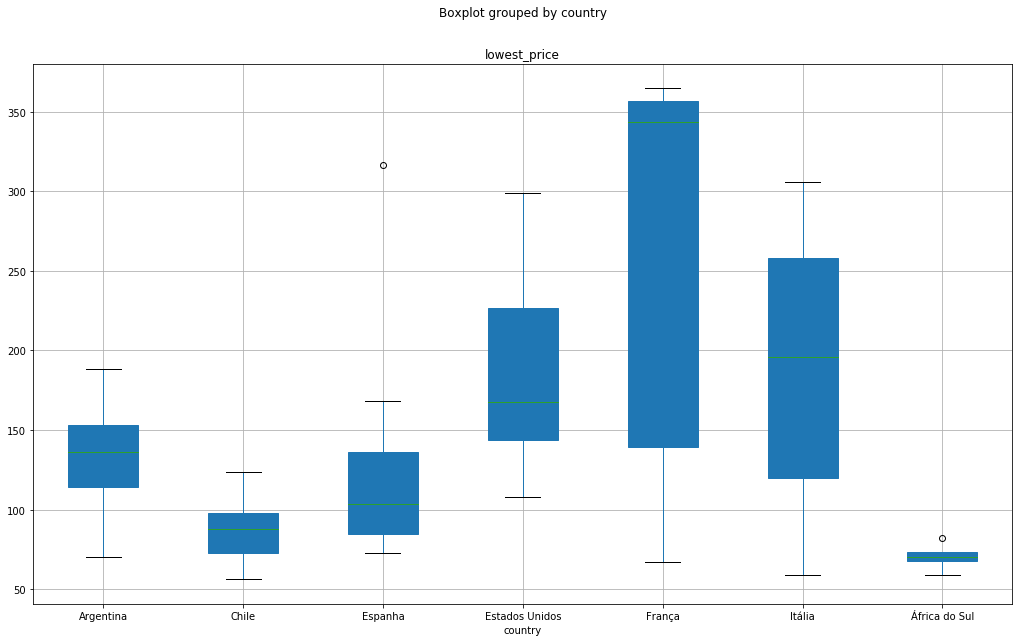

In [36]:
### Referencia: wine_df.loc[(wine_df.evaluation > 3.1) & (wine_df.lowest_price < 200.0) & (wine_df.rating_count > 34.0)].boxplot(by='country',column=['lowest_price'], figsize=(15,10), patch_artist=True)

plot_df = work_df.loc[(work_df.lowest_price <= 400.0) & (work_df.vivino_rating >= work_df.vivino_rating.median())]
plot_df.boxplot(by='country',column=['lowest_price'], figsize=(17,10), patch_artist=True)

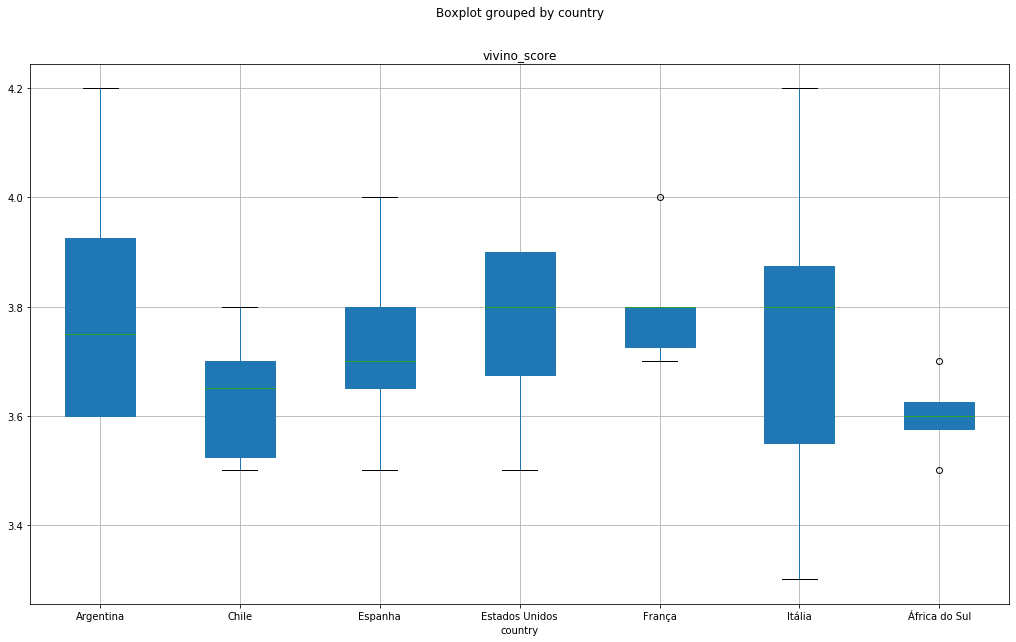

In [37]:
plot_df.boxplot(by='country',column=['vivino_score'], figsize=(17,10), patch_artist=True)

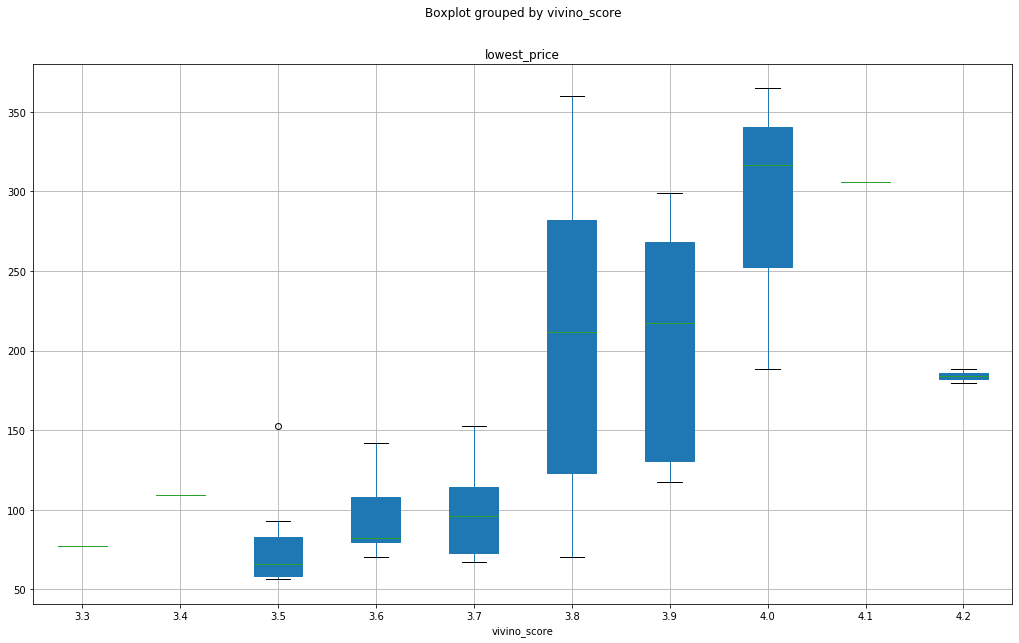

In [38]:
plot_df.boxplot(by='vivino_score',column=['lowest_price'], figsize=(17,10), patch_artist=True)

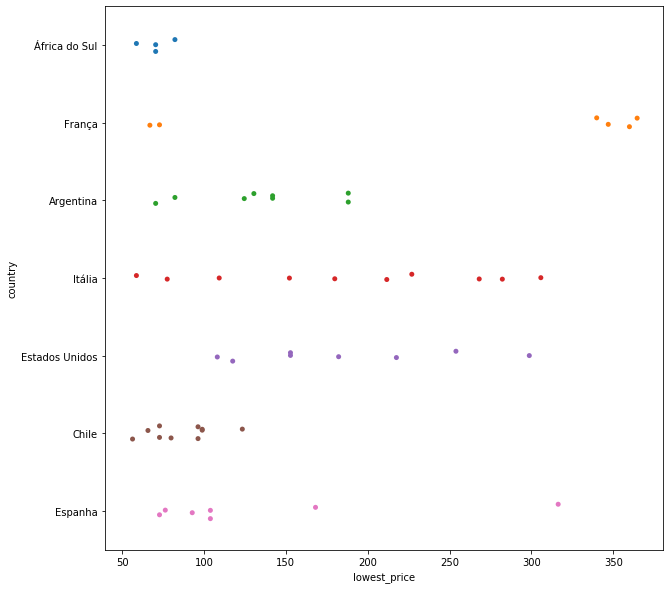

In [39]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(x="lowest_price", y="country", data=plot_df, ax=ax, jitter= True)
plt.show()

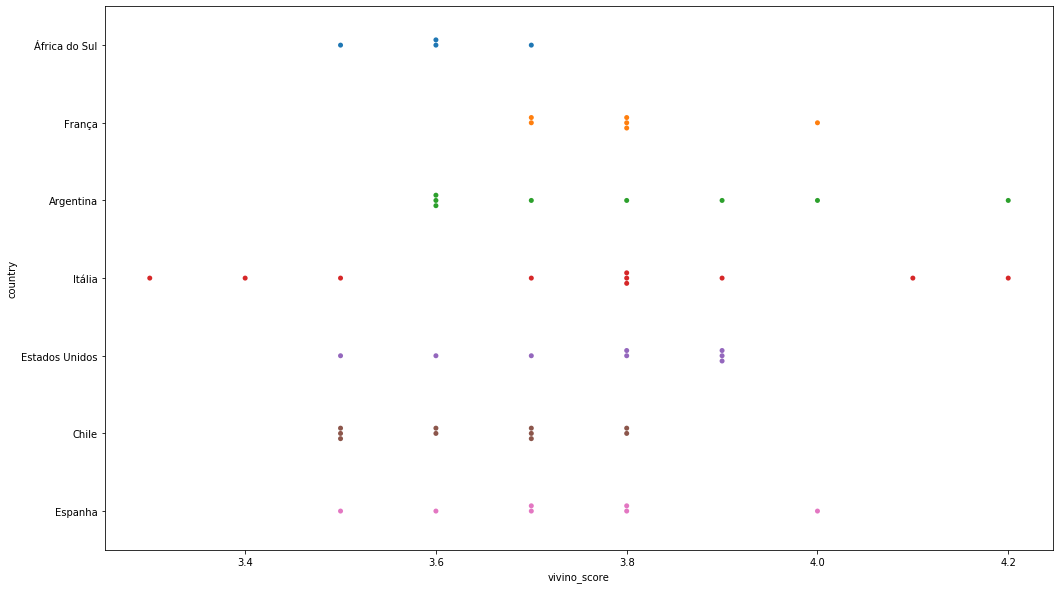

In [40]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="country", data=plot_df, ax=ax)
plt.show()

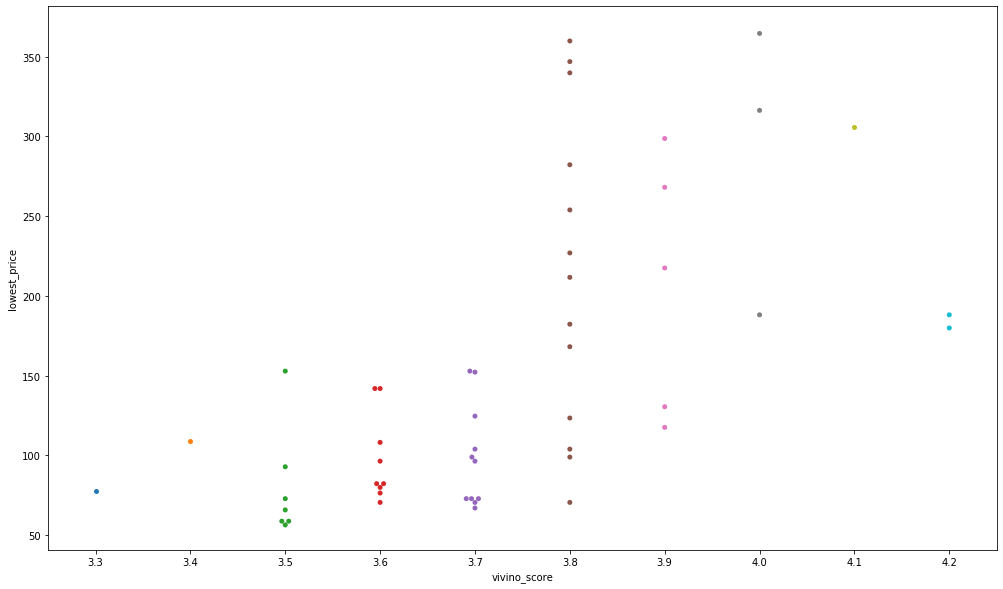

In [41]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="lowest_price", data=plot_df, ax=ax)
plt.show()

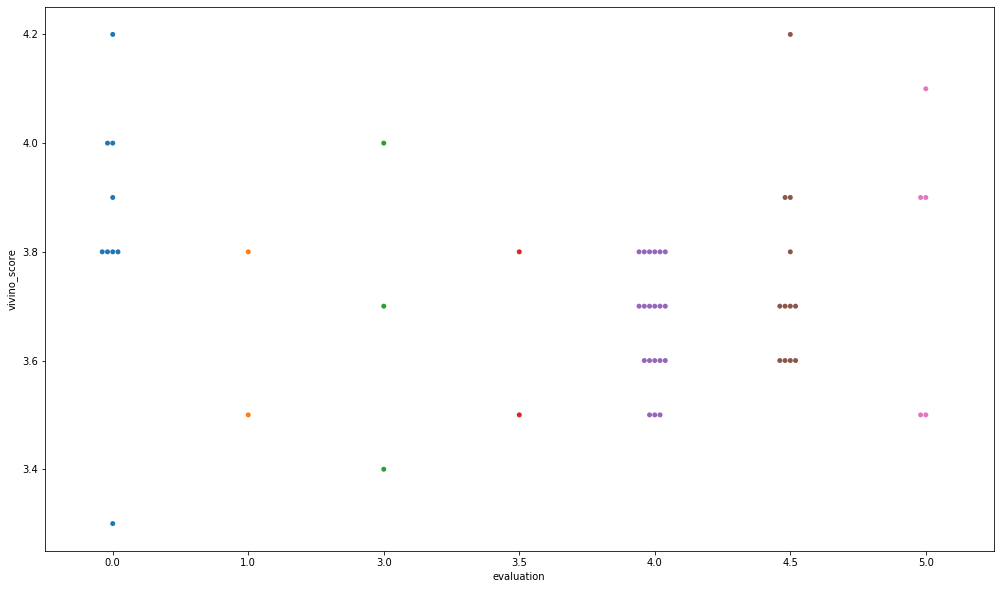

In [42]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="evaluation", y="vivino_score", data=plot_df, ax=ax)
plt.show()

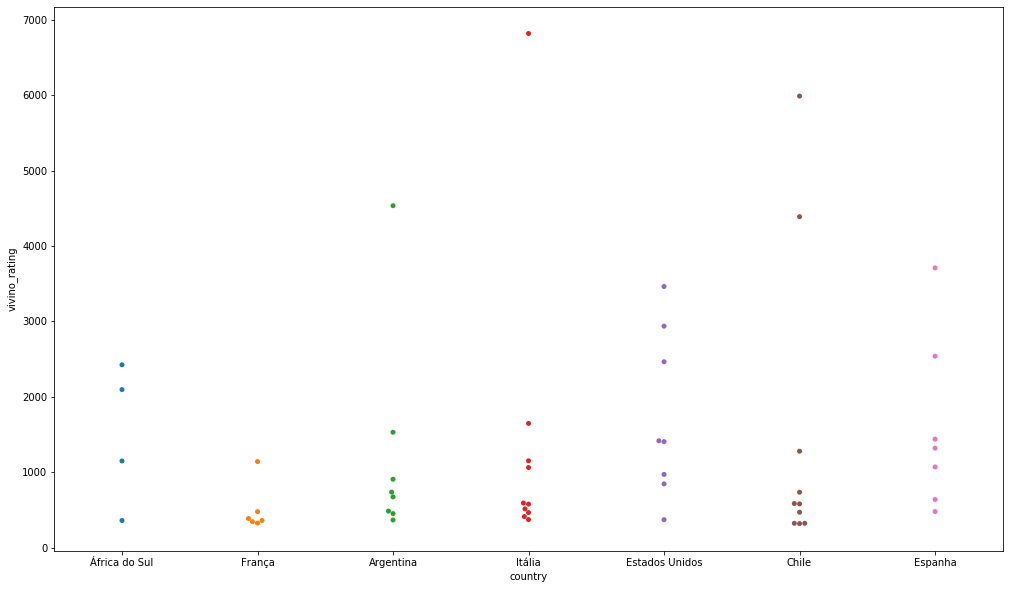

In [43]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="country", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

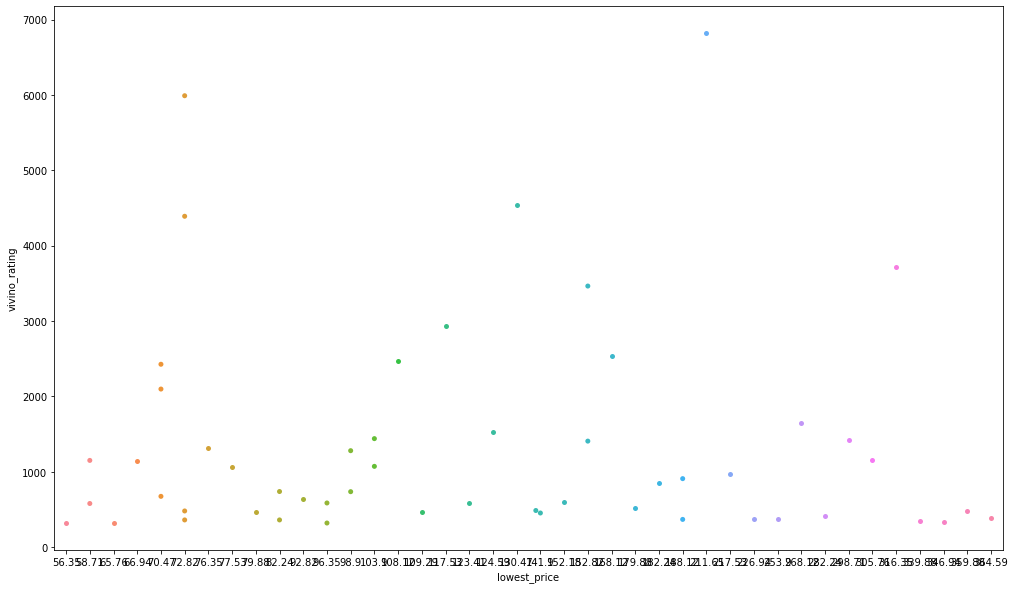

In [44]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="lowest_price", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

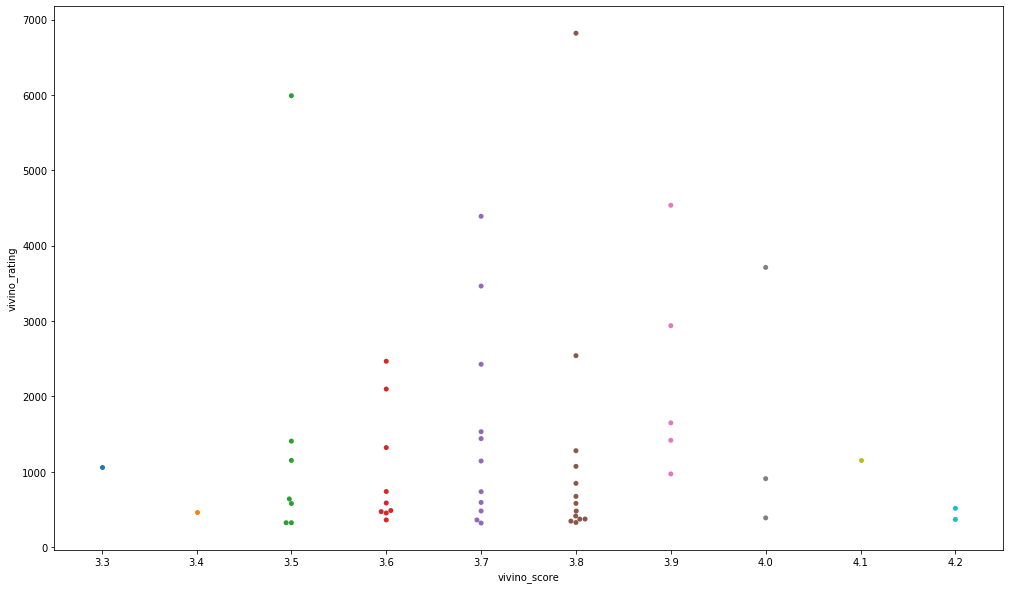

In [45]:
import numpy as np 
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,10))
sns.swarmplot(x="vivino_score", y="vivino_rating", data=plot_df, ax=ax)
plt.show()

In [46]:
menor_preco = work_df.groupby(['country','vivino_score']).apply(lambda df: df.loc[df.lowest_price.idxmin()])
display(menor_preco)

Unnamed: 0  \
country       vivino_score               
Alemanha      3.6                   69   
              4.0                  123   
Argentina     3.5                   49   
              3.6                   34   
              3.7                   12   
...                                ...   
Uruguai       4.3                    8   
África do Sul 3.5                    1   
              3.6                   58   
              3.7                   56   
              4.0                   18   

                                                                    wine_name  \
country       vivino_score                                                      
Alemanha      3.6           Ernst Loosen Winemakers Select Pfalz Edition P...   
              4.0                  Ernst Loosen Pfalz Edition Dornfelder 2018   
Argentina     3.5                                            Tabu Malbec 2017   
              3.6                                    Las Moras Dadá Nº 2 2018   
              3.7                          Partridge Gran Reserva Malbec 2016   
...                                                                       ...   
Uruguai       4.3           Viñedo de los Vientos Angel's Cuvée Ripasso de...   
África do Sul 3.5                                       Tormentoso Syrah 2016   
              3.6                  Lievland Vineyards Cabernet Sauvignon 2017   
              3.7                  Lievland Vineyards Bush Vine Pinotage 2017   
              4.0                                   Fleur Du Cap Laszlo 2015.   

                                                                         link  \
country       vivino_score                                                      
Alemanha      3.6           wine.com.br/vinhos/ernst-loosen-winemakers-sel...   
              4.0           wine.com.br/vinhos/ernst-loosen-pfalz-edition-...   
Argentina     3.5           wine.com.br/vinhos/tabu-malbec-2017/prod24451....   
              3.6           wine.com.br/vinhos/las-moras-dada-n-2-2018/pro...   
              3.7           wine.com.br/vinhos/partridge-gran-reserva-malb...   
...                                                                       ...   
Uruguai       4.3           wine.com.br/vinhos/vinedo-de-los-vientos-angel...   
África do Sul 3.5           wine.com.br/vinhos/tormentoso-syrah-2016/prod2...   
              3.6           wine.com.br/vinhos/lievland-vineyards-cabernet...   
              3.7           wine.com.br/vinhos/lievland-vineyards-bush-vin...   
              4.0           wine.com.br/vinhos/fleur-du-cap-laszlo-2015-/p...   

                                  country   type  \
country       vivino_score                         
Alemanha      3.6                Alemanha  tinto   
              4.0                Alemanha  tinto   
Argentina     3.5               Argentina  tinto   
              3.6               Argentina  tinto   
              3.7               Argentina  tinto   
...                                   ...    ...   
Uruguai       4.3                 Uruguai  tinto   
África do Sul 3.5           África do Sul  tinto   
              3.6           África do Sul  tinto   
              3.7           África do Sul  tinto   
              4.0           África do Sul  tinto   

                                                                  description  \
country       vivino_score                                                      
Alemanha      3.6                      Leve, acidez presente, taninos sedosos   
              4.0             Frutado, leve, acidez agradável, taninos macios   
Argentina     3.5           De médio corpo, taninos macios e com boa persi...   
              3.6                Encorpado, taninos firmes e boa persistência   
              3.7           Estruturado, amadeirado, taninos presentes, fr...   
...                                                                       ...   
Uruguai       4.3           Encorpado, taninos p